In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据的读取与展示

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all),(x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[ :5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[ :5000], y_train_all[5000: ]

### 1.1 数据归一化

In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)

## 2. 模型构建

### 2.1 构建架构

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

# reason for spare:  y->index.   y->one_hot->[ ] 将索引转换为热独向量
model.compile(loss="sparse_categorical_crossentropy",      # 如果已经是热独形式，则用
                                                           # categorical_crossentropy函数
              optimizer ="Adam",               # 使用sgd时会出现Nan的情况
              metrics = ["accuracy"])                      # 关心的参数

### 2.2 查看模型架构

## 3.【重点】训练模型（保存模型和参数）

In [5]:
logdir = "./graph_def_and_weights"
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir, profile_batch=100000000),     # 这里没有设置profile_batch参数时会出问题
    keras.callbacks.ModelCheckpoint(output_model_file, 
                                    save_best_only=True,
                                    save_weights_only=False),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)     # 每次遍历之后都会使用一次验证集验证准确度

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 76us/sample - loss: 0.4565 - accuracy: 0.8324 - val_loss: 0.3526 - val_accuracy: 0.8762
Epoch 2/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3523 - accuracy: 0.8705 - val_loss: 0.3368 - val_accuracy: 0.8784
Epoch 3/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3146 - accuracy: 0.8836 - val_loss: 0.3485 - val_accuracy: 0.8752
Epoch 4/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2919 - accuracy: 0.8912 - val_loss: 0.3445 - val_accuracy: 0.8792
Epoch 5/10
55000/55000 [==============================] - 4s 67us/sample - loss: 0.2721 - accuracy: 0.8976 - val_loss: 0.3347 - val_accuracy: 0.8792
Epoch 6/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.2592 - accuracy: 0.9017 - val_loss: 0.3224 - val_accuracy: 0.8908
Epoch 7/10
55000/55000 [==============================] -

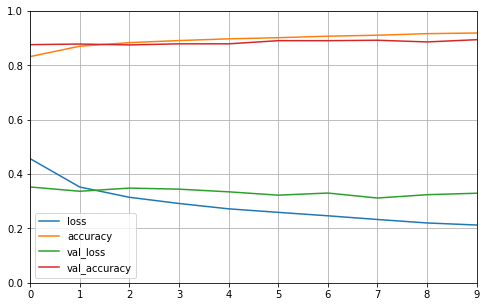

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True) 
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

## 4. 测试数据

In [7]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.36185399423241615, 0.8847]

## 5. 载入模型

In [8]:
loaded_model = keras.models.load_model(output_model_file)
loaded_model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3549239588022232, 0.8854]